# An analysis on the Hybrid Era of Formula 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
drivers = pd.read_csv("../input/formula-1-world-championship-1950-2020/drivers.csv")
circuits = pd.read_csv("../input/formula-1-world-championship-1950-2020/circuits.csv")
lap_time = pd.read_csv("../input/formula-1-world-championship-1950-2020/lap_times.csv")
races = pd.read_csv("../input/formula-1-world-championship-1950-2020/races.csv")
results = pd.read_csv("../input/formula-1-world-championship-1950-2020/results.csv")

In [3]:
#Here are the helper functions that I will be using for this project

#findID: this method takes in a dataframe object and find the driver ID based 
#        the name input. 
#        Currently, the names are hard coded in. Need to find ways to update this. 
def findID(dataframe, name):
    return dataframe[dataframe['driverRef'] == name]["driverId"].iloc[0]


#min_to_sec_converter: covert time in the format of min:sec to seconds. 
#                       This method is not really necessary as miliseconds are 
#                       provided in the data set. Fun to to though
def min_to_sec_converter(time_str):
    min = re.findall("\d+:",time_str)[0].strip(':')
    seconds = re.findall("\:\w+", time_str)[0].strip(':')

    return int(min)*60 + float(seconds)


#function that helps to create a racing summary for each driver's performance in a certain
def racing_summary(driver_stat, driverID):
    summary = {} 
    for raceId in driver_stat[driverID]:
        race_df = driver_stat[driverID][raceId]['milliseconds']
        raceTime = sum(race_df)/1000 # race time in seconds
        
        #len(race_df will effectively be total laps, except in the case of racing incidents)
        ave_lap_time = raceTime/len(race_df)  
        
        std_lap_time = race_df.std()/1000 # divide by 1000000 for data in secs
        summary[raceId] = [raceTime, ave_lap_time, std_lap_time]
        
    return summary
    
#find_driver_code: This method takes in a driver ID and return the Three letter code for the driver.
def find_driver_code (driverID, driver_csv_df):
    return driver_csv_df[driver_csv_df['driverId'] == driverID]['code'].values[0]

#race_time_plot: this method takes in a yearly race_summary_df, a raceId, races
#               data df, and driver data df to plot the total racetime plot of the
#               given race ID. 
def race_time_plot(driver_summary, raceId, races_df, drivers_df):
    fig, ax = plt.subplots(figsize=(10, 5))

    x = [find_driver_code(driverID, drivers_df) for driverID in driver_summary[raceId].keys()]
    y = [driver_summary[raceId][driverID][0] for driverID in driver_summary[raceId]]

    plt.xticks(range(len(x)), x, size = 'medium')
    plt.bar(range(len(y)), y, align = 'center')
    plt.ylim()
    plt.ylabel("Time (s)")
    plt.xlabel('drivers')
    ax.bar(x, y)

    title = "{} Total Race Time".format(get_race_location(raceId, races_df))
    ax.set_title(title)

    plt.show()
    
#get_race_location: this method reads a races_df file and take in a raceId
#                   The method will return a string containg the location 
#                   and year of the give race ID.
def get_race_location(raceId, races_df):
    year = str(races_df[races_df['raceId'] == raceId]['year'].values[0])
    location =  races_df[races_df['raceId'] == raceId]['name'].values[0]
    
    return year + " " + location

#race_pace_dff: this method reads in a race summary dict for the entire season
#               And return a dict {driverId:[total race time, ave lap time, STD]}
#               as difference to the leader. 
def race_pace_diff(raceId, summary_dict, results_df):

    key = results_df[results_df['raceId'] == raceId]['driverId'].reset_index(drop = True)
    #there are issue with the data so have to restrain the key to existing data length. 
    key = key[0:len(summary_dict[raceId])]
    output = {}
    for x in key:
        output[x] = summary_dict[raceId][x]
        
    leader = next(iter(output))
    leader_stat = output[leader].copy()
    sort_output = output.copy()
    for key in sort_output:
        sort_output[key][1] = sort_output[key][1] - leader_stat[1]
        sort_output[key][0] = sort_output[key][0] - leader_stat[0]
    
    #our new dict is now the time differences between entire grid and the leader 
    #in both total race time and average lap. Now we have to remove the DNF data. 
    return dict(filter(lambda x: x[1][0] >= 0, sort_output.items()))

#race_pace_dff_plot: this method Plots the result from race_pace_diff function
def race_pace_diff_plot(race_diff_output, drivers_df, raceID, races_df):
    fig, ax = plt.subplots(figsize=(10, 5))

    x = [find_driver_code(driverID, drivers_df) for driverID in race_diff_output.keys()]
    y = [race_diff_output[driverID][1] for driverID in race_diff_output]
    
    plt.xticks(range(len(x)), x, size = 'medium')
    plt.bar(range(len(y)), y, align = 'center')
    plt.ylim()
    plt.ylabel("Time (s)")
    plt.xlabel('drivers')
    ax.bar(x, y)
    
    title = "{} average lap time \nDifference to Leader".format(get_race_location(raceID, races_df))
    ax.set_title(title)
    
    plt.show()
    

now we can try to categorize some racing data based on each driver. driving data is all categorized by driver ID, and we can deal with the drivers based on this number. 

In [4]:
drivers[["driverRef","driverId"]]

,driverRef,driverId
0,hamilton,1
1,heidfeld,2
2,rosberg,3
3,alonso,4
4,kovalainen,5
...,...,...
849,aitken,851
850,tsunoda,852
851,mazepin,853
852,mick_schumacher,854


The existing lap time data in the data set is quite hard to work with. I will first sort the data into python dictionaries. I am using the driverIDs as the key,and a pd dataframe containing all of their lap times as the associated values in the dictionary. 

In [5]:
indiv_driver_lap = {ID:lap_time.loc[lap_time['driverId'] == ID].reset_index(drop = True) for ID in drivers.driverId}
indiv_driver_lap[findID(drivers,"hamilton")]
#findID is a helper function that help me find the driverID from the existing drivers data set. 

,raceId,driverId,lap,position,time,milliseconds
0,841,1,1,2,1:40.573,100573
1,841,1,2,2,1:33.774,93774
2,841,1,3,2,1:32.900,92900
3,841,1,4,2,1:32.582,92582
4,841,1,5,2,1:32.471,92471
...,...,...,...,...,...,...
16597,1076,1,54,4,1:22.108,82108
16598,1076,1,55,4,1:22.105,82105
16599,1076,1,56,4,1:22.407,82407
16600,1076,1,57,4,1:22.623,82623


With this new dictionary, we can now access the driver data more easily. However, I want to create a layered data structure where you can search for specific data in a more intuitive way. In this case, I am choosing to establish **nested dictionaries** for each drivers and each of their race, so that you can specify the driver and raceID to gain access to their full racing information. This dictionary can be easily used to derive further summary statistics and data analysis.

The final data structure that I have created takes the following form. 
**driver_stat = {driverID:{raceId:dataframe}}** 

you can search for a driver with their driverID and look for a specific race by using simple python dictionary syntax. For example, I looked up the historical data of michael Schumacher with the following syntax.

In [6]:
#this is quite a convoluted dictionary comprehension. What I did here was essentially slicing the original dataframe based on driverId, and slicing again based on the raceId. 
driver_stat = {driverId:{raceId:indiv_driver_lap[driverId].loc[indiv_driver_lap[driverId]['raceId']==raceId].reset_index(drop = True) for raceId in races['raceId'] if raceId in indiv_driver_lap[driverId]['raceId'].values} for driverId in drivers.driverId}

In [7]:
#quick example with one of the greatest driver in the history. 
driver_stat[findID(drivers, "michael_schumacher")][171][:10]

,raceId,driverId,lap,position,time,milliseconds
0,171,30,1,1,1:37.034,97034
1,171,30,2,1,2:33.280,153280
2,171,30,3,1,2:29.489,149489
3,171,30,4,1,2:28.507,148507
4,171,30,5,1,2:29.794,149794
5,171,30,6,1,2:30.571,150571
6,171,30,7,1,2:28.819,148819
7,171,30,8,1,2:28.003,148003
8,171,30,9,1,2:28.118,148118
9,171,30,10,1,2:28.641,148641


With this data structure set up, we can use it to explore some interesting topics in formula history. For this project specifically, I will be taking a look at the recent Hybrid era of the sport. I am a newcomer to the sport and I witness the great battle between Max Vestappen and Lewis Hamilton in 2021. The extremely close outcome movitated me to see how Mercedes-AMG was able to reign over the hybrid era, and how Hamilton was able to keep winning despite insisting *"Bono, my tires are gone"*.

### Analysis of the 2014 season. 

Formula 1 undergone significant regulations changes in 2014 as **2.4 liters V8 engines** were switched to **1.6 liters V6 hybrid power units**. This shift has resulted in perhaps the most significant changes in the sports as the Mercedes-AMG team showed complete dominance during this era. The team won all 8 constructor championships during this regulation cycle until new rules were introduced to the 2022 season. Now let's explore how the drivers of this era fared against th e 7 times world champion that is Lewis Hamilton, and how Nico Rosberg and Max Vestappen was able to wrestle two championships from him. 

In [8]:
ham_summary = {}
for raceId in driver_stat[findID(drivers,"hamilton")]:
    race_df = (driver_stat[findID(drivers,"hamilton")][raceId]['milliseconds'])
    raceTime = sum(race_df)/1000 # race time in seconds
    ave_lap_time = raceTime/len(race_df)   #len(race_df will effectively be total laps, except in the case of racing incidents)
    std_lap_time = ((race_df).std())/1000
    
    ham_summary[raceId] = [raceTime, ave_lap_time, std_lap_time]
  
#final data structure is as follows: ham_summary = dict{raceID:[race time, ave lap time, std lap time]}
#this function is also summed into a function that can be found in scripts.py

We can begin by constructing some summary statistics on all of the F1 drivers. I am mostly focusing on the actual race here without too much attention to qualifying races just yet. The analysis of the qualifying races will be conducted in later parts of the project. As far as car performance and driver skills, the lap time data should be the best estimator for the driver/car duo. 

In [9]:
#racing_summary is a helper function that I created to calculate the total race time, average lap time, and the standard deviation of the lap times. 
# These three summary statistics should suffice for our initial exploration of each driver's performance. 
all_driver_racing_sum = {id:racing_summary(driver_stat,id) for id in driver_stat}

In [10]:
#creating a list containing only the races of the 2014 season
races_2014 = list(races.loc[races['year'] == 2014]['raceId'].reset_index(drop = True))

In [11]:
driver_summary_2014 = {}

for raceId in races_2014:
    tmp = {}
    for driverId in driver_stat:
        if raceId in all_driver_racing_sum[driverId].keys():
            tmp[driverId] = all_driver_racing_sum[driverId][raceId]
            
    driver_summary_2014[raceId] = tmp

#The structure of driver_summary_2014 is dict = {RaceID:{driverId:[total race time, lap average, lap_time STD]}}

**driver_summary_2014** contains the is the total race_time, average pace, and lap time STD of all participating drivers in the 2014 season. Now let's take a look at the average lap time of each driver in the 2014 Spanish Grand Prix.

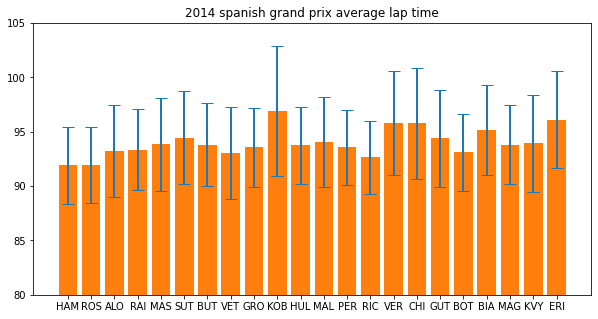

In [12]:
#this method will be packaged into a function to reduce further trouble. 
fig, ax = plt.subplots(figsize=(10, 5))

x = [find_driver_code(driverID, drivers) for driverID in driver_summary_2014[904].keys()]
y = [driver_summary_2014[904][driverID][1] for driverID in driver_summary_2014[904]]
err = [driver_summary_2014[904][driverID][2] for driverID in driver_summary_2014[904]]

plt.xticks(range(len(x)), x, size = 'medium')
ax.errorbar(x, y, err, fmt = 'none', linewidth = 2, capsize = 6)
plt.bar(range(len(y)), y, align = 'center')
plt.ylim(80,105)
ax.bar(x, y)
ax.set_title("2014 spanish grand prix average lap time")

plt.show()

We can also compare the total race time for each driver as well.

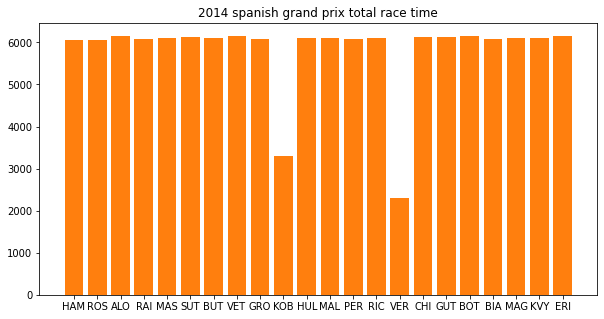

In [13]:
# will be packaged into function later.
fig, ax = plt.subplots(figsize=(10, 5))

x = [find_driver_code(driverID, drivers) for driverID in driver_summary_2014[904].keys()]
y = [driver_summary_2014[904][driverID][0] for driverID in driver_summary_2014[904]]

plt.xticks(range(len(x)), x, size = 'medium')

#ax.set_xticklables(x_ticks_lables, rotation = 'vertical', fontsize = 10)
plt.bar(range(len(y)), y, align = 'center')
plt.ylim()
ax.bar(x, y)
ax.set_title("2014 spanish grand prix total race time")

plt.show()

However, we can obviously see that my current bar graph is not too useful, as the differences between each driver is not really that much. The average pace between the top drivers only differs by a small percentage and it is hard to observe visually. 

Another approach to data analysis is to calculate the time difference between each driver and the eventual winner of the race. Aside from a few special cases (penalties, etc) this approach should best highlight key statistical differences between the driver. 

In [14]:
#still working with the Spanish Grand Prix
raceID = 904

key = results[results['raceId'] == raceID]['driverId'].reset_index(drop = True)
output = {}
for x in key:
    output[x] = driver_summary_2014[raceID][x]
    
leader = next(iter(output))
leader_stat = output[leader].copy()
sort_output = output.copy()

for key in sort_output:
    sort_output[key][1] = sort_output[key][1] - leader_stat[1]
    sort_output[key][0] = sort_output[key][0] - leader_stat[0]

#our new dict is now the time differences between entire grid and the leader in both total race time and average lap. Now we have to remove the DNF data. 
sort_output = dict(filter(lambda x: x[1][0] >= 0, sort_output.items()))

#now our dict is only the summary statistics of the race for those who finished! we can now proceed to plot this. 
#TODO: find out why the total time looks weird. The race time got reset at position 7. KIMI got lapped here. Need to check out how the data is recorded. 

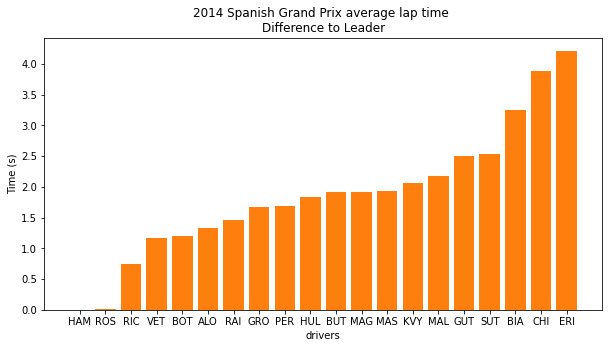

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

x = [find_driver_code(driverID, drivers) for driverID in sort_output.keys()]
y = [sort_output[driverID][1] for driverID in sort_output]

plt.xticks(range(len(x)), x, size = 'medium')
plt.bar(range(len(y)), y, align = 'center')
plt.ylabel("Time (s)")
plt.xlabel('drivers')
ax.bar(x, y)

title = "{} average lap time \nDifference to Leader".format(get_race_location(raceID, races))
ax.set_title(title)

plt.show()

Now this is much better! I have decided not to visualize the total race time data as there is almost no way to present it cleanly with the presence of lapped drivers and DNFs. 

we see that Hamilton and Rosbery are significantly outpacing the rest of the grid. Moreover, the difference between ROS and HAM is extremely small. This rivalry will eventually come to fruition in the 2016 season. 

**Let's package the previous scripts and look at a couple more races in 2014**

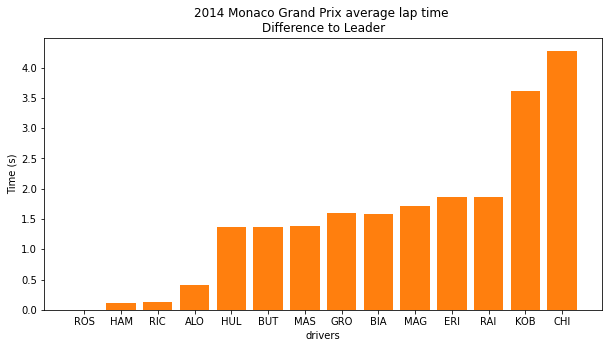

In [16]:
monaco_2014_ID = 905
monaco_2014 = race_pace_diff(monaco_2014_ID, driver_summary_2014, results)
race_pace_diff_plot(monaco_2014, drivers, monaco_2014_ID, races)

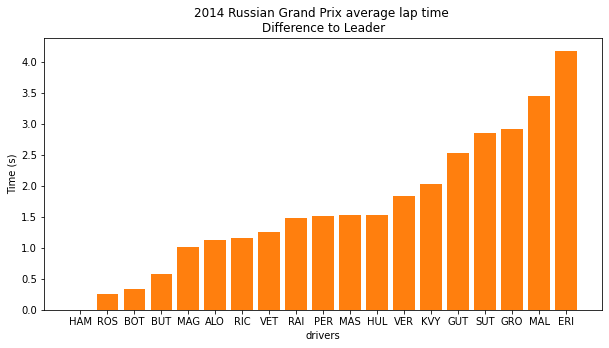

In [17]:
Russia_2014_ID = 915
Russia_2014 = race_pace_diff(Russia_2014_ID, driver_summary_2014, results)
race_pace_diff_plot(Russia_2014, drivers, Russia_2014_ID, races)

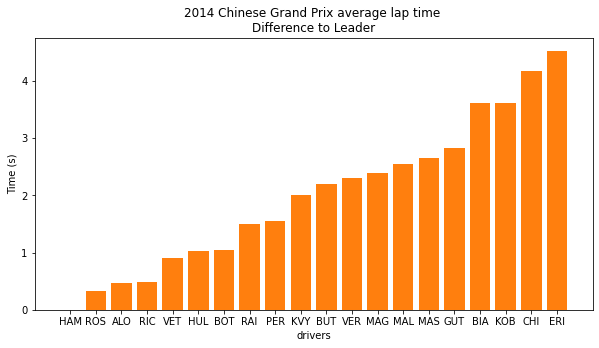

In [18]:
China_2014_ID = 903
China_2014 = race_pace_diff(China_2014_ID, driver_summary_2014, results)
race_pace_diff_plot(China_2014, drivers, China_2014_ID, races)

China_2014_ID = 903
China_2014 = race_pace_diff(China_2014_ID, driver_summary_2014, results)
race_pace_diff_plot(China_2014, drivers, China_2014_ID, races)

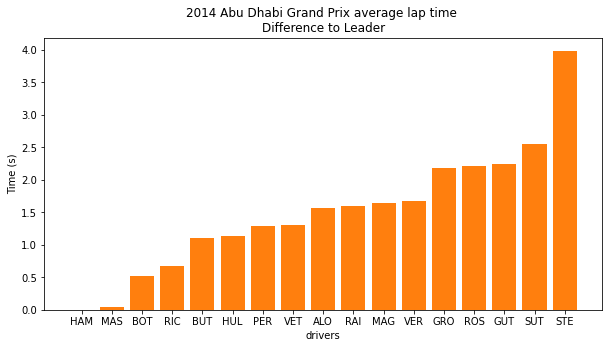

In [19]:
Adu_2014_ID = 918
Adu_2014 = race_pace_diff(Adu_2014_ID, driver_summary_2014, results)
race_pace_diff_plot(Adu_2014, drivers, Adu_2014_ID, races)

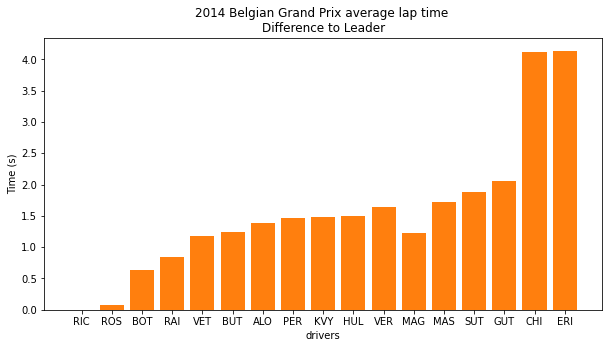

In [20]:
Belgian_2014_ID = 911
Belgian_2014 = race_pace_diff(Belgian_2014_ID, driver_summary_2014, results)
race_pace_diff_plot(Belgian_2014, drivers, Belgian_2014_ID, races)

In [21]:
#Note: Kevin Magnussen initially finished 6th, but was handed a 20 second penalty for forcing Fernando alonso off track. The x axis is sorted by race outcome with the left being the winner. 
#      The 20 second penalty was not reflected in the lap time data. 

We can see that Hamilton and Rosberg led the whole grid with a substantial lead. In most of the races showcased here, the Mercs about 0.5 second lead in average lap time across different race trace styles and throughout the season. Moreoever, the mercedes lead the mid field with about 1.5 second and the back of the field with 2-3 seconds at least. Even though both drivers at the team were superb. There is no denying that mercedes cars were simply uncontested. Even in the races where Daniel Ricardo won, the mercs were keeping up their average lap time within couple of tenths of seconds. 

Another approach we can take is to see the stability of each driver throughout the season. We can gauge this by taking a look at the drivers' lap time standard deviations. 

In [22]:
driver_std = {driverId: [driver_summary_2014[races][driverId][2] if driverId in driver_summary_2014[races] else 0 for races in races_2014] for driverId in driver_summary_2014[900]}
driver_list = list(driver_std.keys())

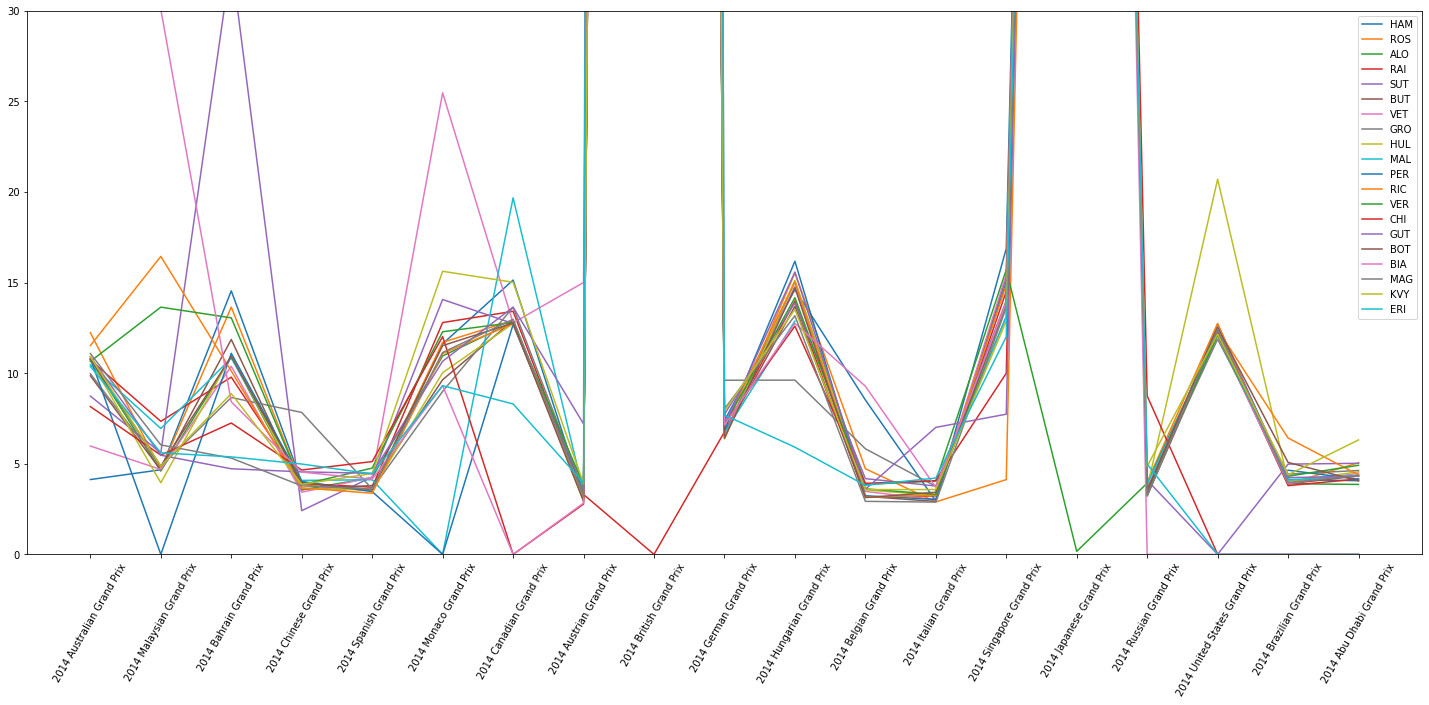

In [23]:
fig, ax = plt.subplots(figsize=(25, 10))

driver_codes = [find_driver_code(driverId, drivers) for driverId in driver_list]
race_locations = [get_race_location(race,races) for race in races_2014]

for driver in driver_list:
    plt.plot(race_locations, driver_std[driver])
    
plt.legend(labels = driver_codes)
plt.xticks(rotation = 60)   
plt.ylim(0,30) 

plt.show()

As we can see, ploting the lap time standard deviation of all 20 drivers can can get a bit hectic, let's zoom in on the top 5 drivers of that year: **Hamilton, Rosberg, Ricciardo, Bottas, and Vettle**. 

In [24]:
driver_codes = [find_driver_code(driverId, drivers) for driverId in driver_list]
race_locations = [get_race_location(race,races) for race in races_2014]

#remove two races where a incident caused unreasonable lap times. 
race_locations.pop(8)
race_locations.pop(13)
for driver in driver_std:
    driver_std[driver].pop(8)
    driver_std[driver].pop(13)

top_5 = [1,3,817,822,20]

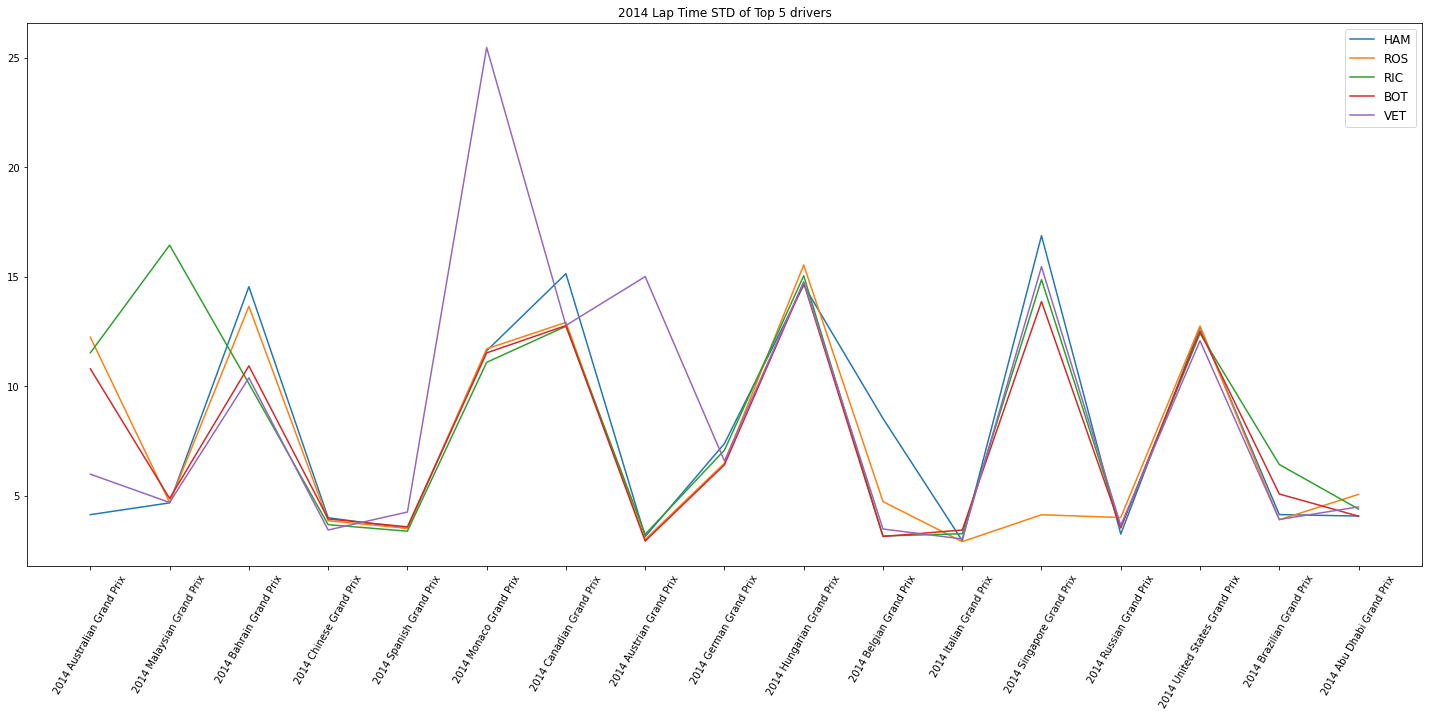

In [25]:
fig, ax = plt.subplots(figsize=(25, 10))

for driver in top_5:
    plt.plot(race_locations, driver_std[driver])
    
plt.legend(labels = [find_driver_code(driverId, drivers) for driverId in top_5], fontsize = 'large')
plt.xticks(rotation = 60)
plt.title("2014 Lap Time STD of Top 5 drivers", fontsize = 'large')

plt.show()

From this graph, we can fairly confidently asssert that aside from Vettle having several outliers, the top 5 drivers all had very consisent lap_times throughout the entire season. 

With the data analysis that we conducted so far, two key factors stands out:
1. The consistency of the top driver in the 2014 season was fairly similar thoughout the whole season. 
2. The Mercedes cars had significant advantage over the rest of the grid as both Hamilton and Rosberg had large pace advantages. 

In other words, the championship was mostly a fight between Rosberg and Hamilton, as no other drivers were consistently achieving good results against them. Daniel Ric was close but he wasn't able to secure the podium in most of the races where the mercs won. 

Before we move in, let's take a look at the cumulative points over the entire season.

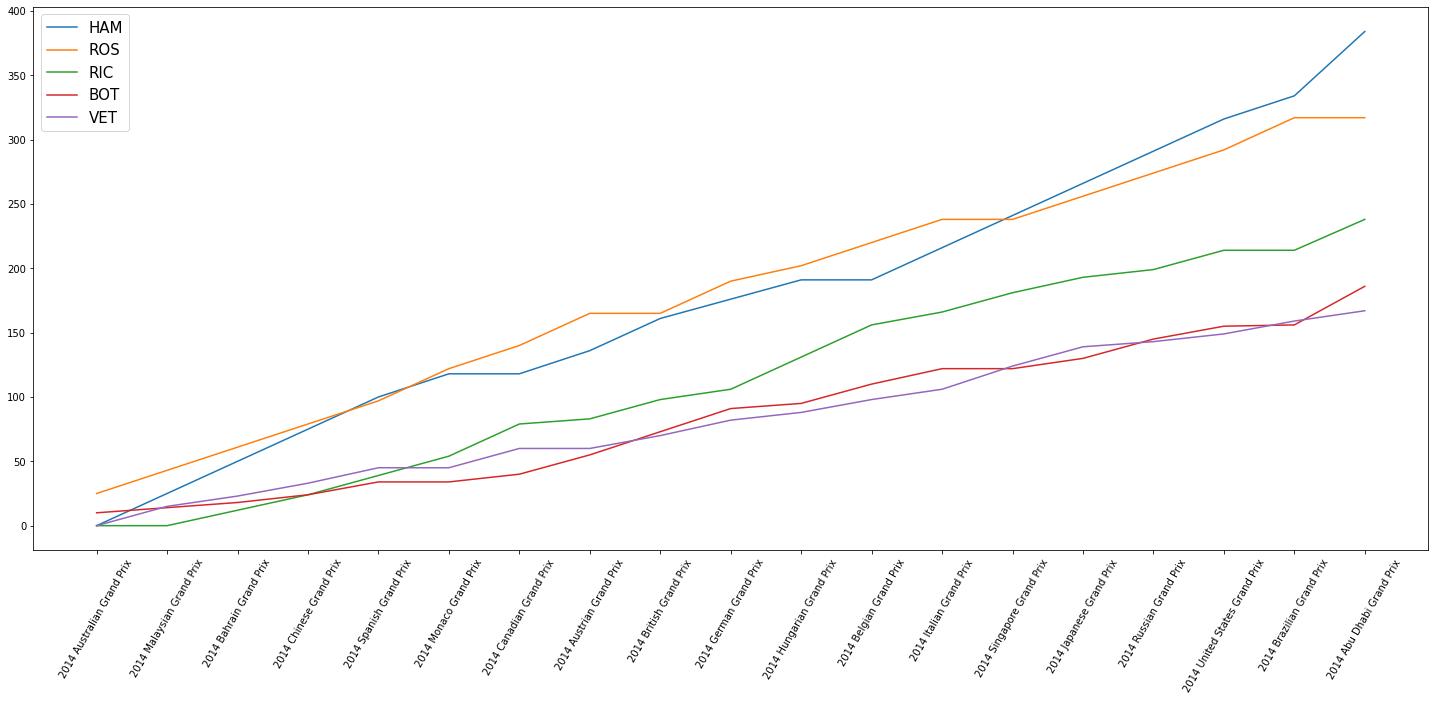

In [26]:
top_5 = [1,3,817,822,20]

fig, ax = plt.subplots(figsize=(25, 10))

for driver in top_5:
    points = [results[(results['raceId'] == race) & (results['driverId'] == driver)]['points'].values[0] for race in races_2014]
    cumulative_points = 0;
    total = []
    for x in points:
        cumulative_points += x
        total.append(cumulative_points)
    
    plt.plot([get_race_location(race, races) for race in races_2014],total)

plt.xticks(rotation = 60)
plt.legend(labels = [find_driver_code(driverId, drivers) for driverId in top_5], loc = 0, prop={'size': 15})

plt.show()

### 2016 season: The rise of Nico Rosberg

Since 2014, the AMG-Mercedes team has won every single constructor championship, meaning that the team's two drivers had the highest combined score on the grid. Over the 8 years, Lewis Hamilton was showing unbelievable dominance that was only match by two drivers: Nico Rosberg, and Max Vestappen. In the next analysis, we will take a look at the 2016 season where Nico Rosberg was able to beat Hamilton out.

In [27]:
# The analysis here is the same as the 2014 season. 
races_2016 = list(races.loc[races['year'] == 2016]['raceId'].reset_index(drop = True))
driver_summary_2016 = {}

for raceId in races_2016:
    tmp = {}
    for driverId in driver_stat:
        if raceId in all_driver_racing_sum[driverId].keys():
            tmp[driverId] = all_driver_racing_sum[driverId][raceId]
            
    driver_summary_2016[raceId] = tmp


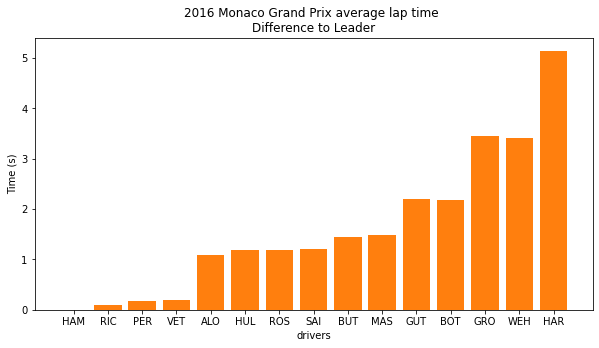

In [28]:
monaco_2016_ID = 953
monaco_2016 = race_pace_diff(monaco_2016_ID, driver_summary_2016, results)
race_pace_diff_plot(monaco_2016, drivers, monaco_2016_ID, races)

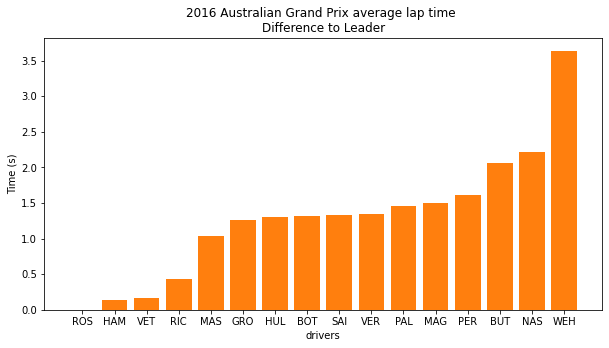

In [29]:
ID = 948
race = race_pace_diff(ID, driver_summary_2016, results)
race_pace_diff_plot(race, drivers, ID, races)

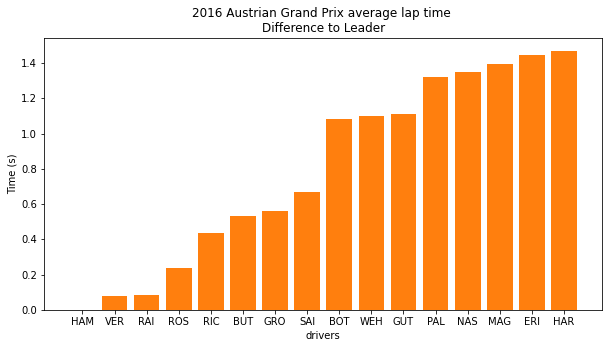

In [30]:
ID = 956
race = race_pace_diff(ID, driver_summary_2016, results)
race_pace_diff_plot(race, drivers, ID, races)

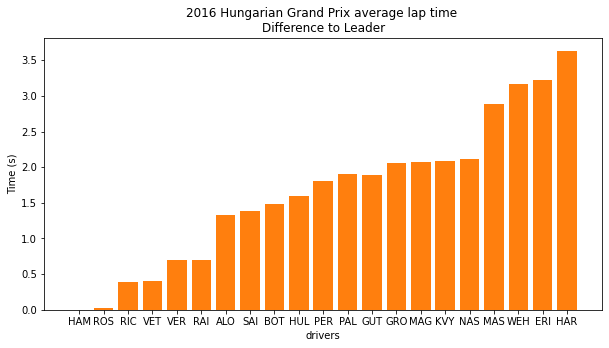

In [31]:
ID = 958
race = race_pace_diff(ID, driver_summary_2016, results)
race_pace_diff_plot(race, drivers, ID, races)

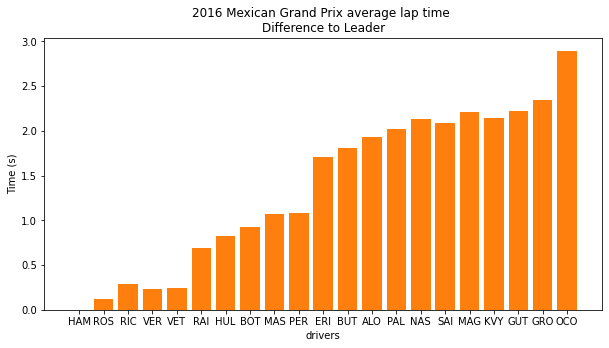

In [32]:
ID = 966
race = race_pace_diff(ID, driver_summary_2016, results)
race_pace_diff_plot(race, drivers, ID, races)

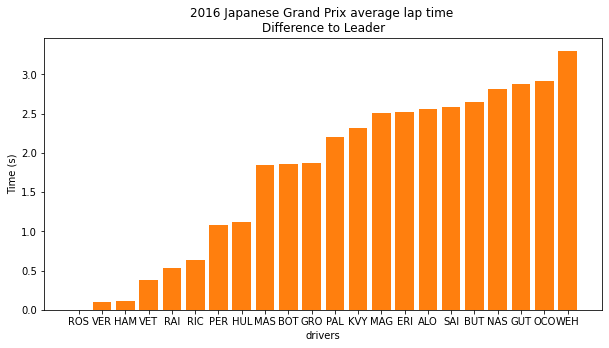

In [33]:
ID = 964
race = race_pace_diff(ID, driver_summary_2016, results)
race_pace_diff_plot(race, drivers, ID, races)

In [34]:
driver_std = {driverId: [driver_summary_2016[races][driverId][2] if driverId in driver_summary_2016[races] else 0 for races in races_2016] for driverId in driver_summary_2016[964]}
driver_list = list(driver_std.keys())

driver_codes = [find_driver_code(driverId, drivers) for driverId in driver_list]
race_locations = [get_race_location(race,races) for race in races_2016]

#remove three races with outlier STDs
race_locations.pop(19)
race_locations.pop(12)
race_locations.pop(0)
for driver in driver_std:
    driver_std[driver].pop(19)
    driver_std[driver].pop(12)
    driver_std[driver].pop(0)
    
    
top_5 = [3,1,817,20,830]

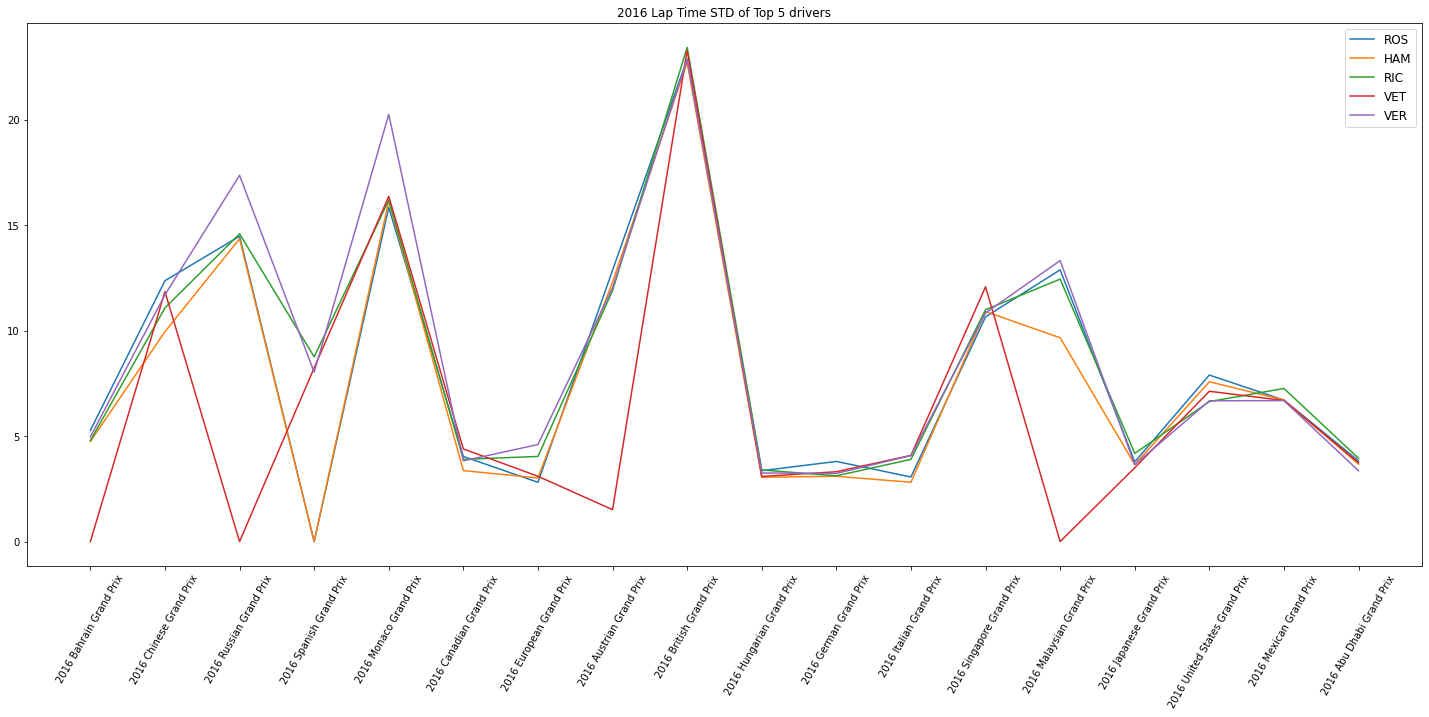

In [35]:
fig, ax = plt.subplots(figsize=(25, 10))

for driver in top_5:
    plt.plot(race_locations, driver_std[driver])
    
plt.legend(labels = [find_driver_code(driverId, drivers) for driverId in top_5], fontsize = 'large')
plt.xticks(rotation = 60)
plt.title("2016 Lap Time STD of Top 5 drivers", fontsize = 'large')

plt.show()

The 2016 season paints a extremely competitive season for the two drivers in the Mercedes team. As far as pace and lap time consistency goes, there is really no difference between Nico Rosberg and Lewis Hamilton. A simple glance at the average pace of the race cannot really tell how close the year has been for Nico Rosberg. A proper visualization of the cumulative points progression could help us understand the drama within the season better.

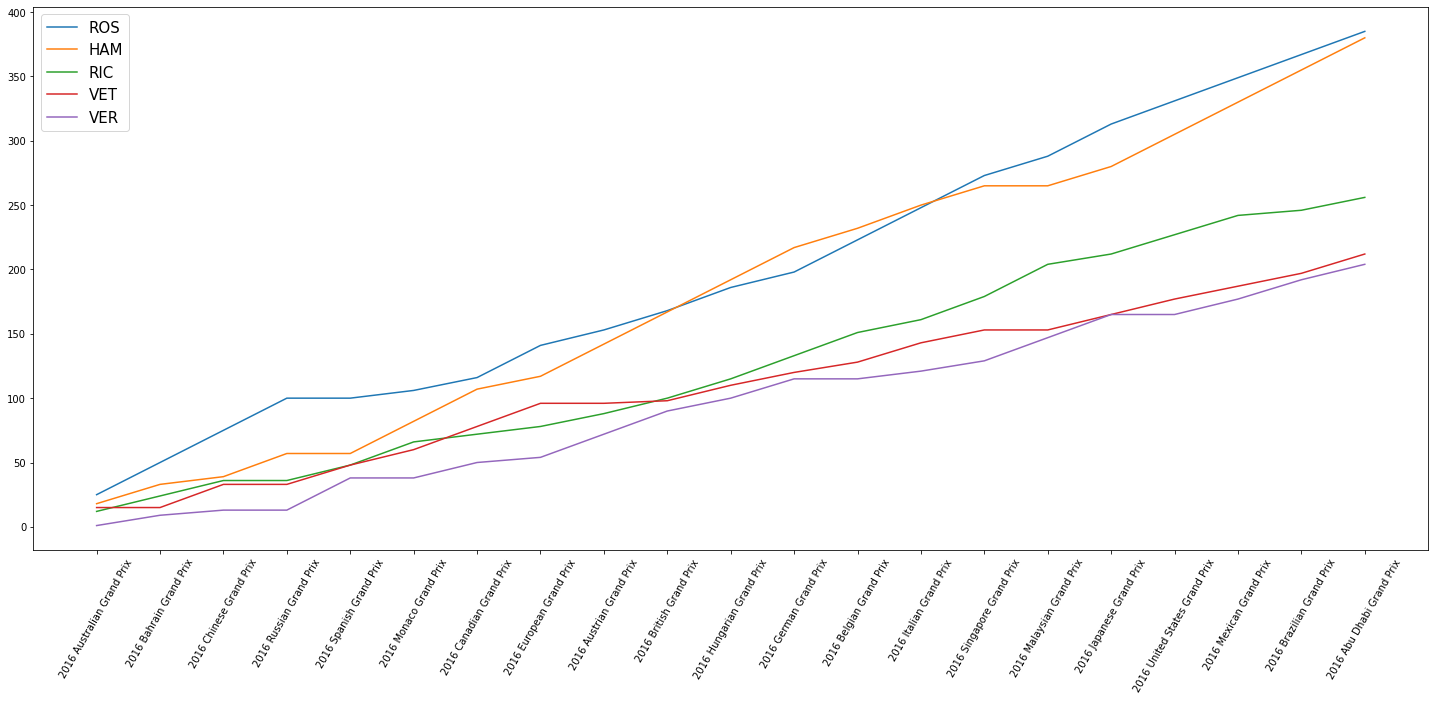

In [36]:
top_5 = [3,1,817,20,830]

fig, ax = plt.subplots(figsize=(25, 10))

for driver in top_5:
    points = [results[(results['raceId'] == race) & (results['driverId'] == driver)]['points'].values[0] for race in races_2016]
    cumulative_points = 0;
    total = []
    for x in points:
        cumulative_points += x
        total.append(cumulative_points)
    
    plt.plot([get_race_location(race, races) for race in races_2016],total)

plt.xticks(rotation = 60)
plt.legend(labels = [find_driver_code(driverId, drivers) for driverId in top_5],loc = 0, prop={'size': 15})

plt.show()

Lewis hamitlon attempted to come back after the 2014 malaysia race, and he was catching up with Nico Rosberg race by race. The championship was not decided until the very last race in Abu Dhabi. If Hamilton win the last race, Nico Rosberg needed at least a 3rd place to bring it all home. In the end, Nico Rosberg finished 2nd and became the new WDC. 

## some fun exploratory data analysis on the F1 data set

Even though I could do another analysis on the rivalry between Max Vestappen and Lewis Hamilton in 2021, the process will be very similiar to the analysis above given the available data. Thus, I have decided to explore some other questions. 
There are two things that I am interested in: 
1. How important is qualifying to the final outcome? 
2. Who was the most unlucky driver of F1? 

Please let me know if there are any other interesting topic that you think could be solved with the available data

#TODO: add starting position and finish position analysis. Perhaps on Monaco and some other circuits. 

### The importance of qualifying

For this topic, I will be taking a look at all of the available racing data in the data set. Although it might be helpful to split 70 years of data into several eras to see if the importance of qualifying changes, my knowledge of the sport is still quite limited at this point. I might come back again to explore this a bit more. 

For the sake of simplicity, data where the driver didn't receive a final placement due to DNFs was removed from the analysis. 

In [37]:
qualifying = pd.read_csv('../input/formula-1-world-championship-1950-2020//qualifying.csv')

In [38]:
race_history = list(races['raceId'])

In [39]:
#get finish position
quali_final_pairs = []
for race in race_history: 
    for id in results[results['raceId'] == race]['driverId']:
        quali_final_pairs.append([qualifying[(qualifying['raceId']==race) & (qualifying['driverId']==id)]['position'].values, results[(results['raceId']==race) & (results['driverId']==id)]['position'].values])


In [40]:
#remove the DNFs
quali_final = []

for x in quali_final_pairs:
    if (x[1].any() != '\\N') & (len(x[1]) == 1) & (len(x[0]) == 1): #there are some weird scenarios where there is no value in either the qualifying or the final results
        quali_final.append([int(x[0]),int(x[1])])


In [41]:
quali = []
final = []
for x in quali_final:
    quali.append(x[0])
    final.append(x[1]) 
    
coeffs = np.polyfit(quali,final, deg = 1)
pred = list(map(lambda x: coeffs[0]*x + coeffs[1], quali))
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(final, pred)

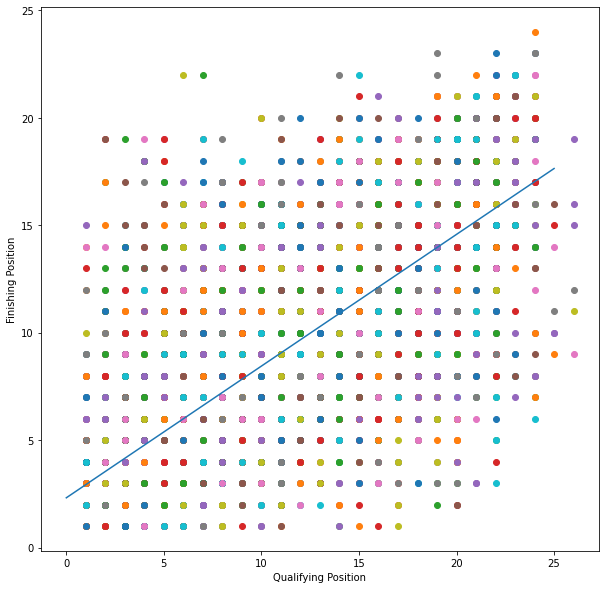

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
for x in quali_final:
    plt.scatter(x[0],x[1])    

y = []
for x in range(26):
    y.append(0.613*x + 2.317)
plt.plot(range(26),y)
plt.ylabel("Finishing Position")
plt.xlabel('Qualifying Position')

plt.show()

Based on the pairs of qualifying and finishing positions, there is a weak correlation between the two data points. The data set shows quite strong deviations from the best fit line. There are a lot of examples where a driver moved up to the front with bad qualifying or dropped off after an amazing quali session. As I mentioned before, things are changing quite a bit as the sport progresses. Monaco has became known for very qualifying dependent as the tight street of Monaco is not too fit for the larger modern F1 cars. Such an analysis will hopefully conducted int the future with the help of more data on car changes. 

### The unluckiest driver in history

For this analysis, I will be taking a look at the unluckiest driver in F1 history. 
There are a two criteria that I am looking at:
1. A driver receives a DNF due to external circumstances aside from collisions, DNQ, DSQ, and violation to the 107% rule. A racing incident is counted as an unlucky occurence. 
2. Only drivers with more than 30 races will be considered for final qualification. 

In [43]:
DNFs = results[results['position'] == '\\N'].sort_values('driverId')
#find all the DNFs 
DNFs = DNFs[(DNFs['statusId'] != 4) & (DNFs['statusId'] != 81) & (DNFs['statusId'] != 77)&(DNFs['statusId'] != 2) ]

In [44]:
driver_IDs = DNFs['driverId'].unique()

In [45]:
filtered_ids = []
for driver in driver_IDs:
    if len(results[results['driverId'] == driver]) > 30:#only keep drivers with more than 30 races. 
        filtered_ids.append(driver)
        
len(filtered_ids)

210

In [46]:
percentage_DNFs = {}
for id in filtered_ids:
    x = len(DNFs[DNFs['driverId'] == id])
    y = len(results[results['driverId'] == id])
    percentage_DNFs[id] = [x/y * 100]


In [47]:
sorted_percentage_DNFs = list(sorted(percentage_DNFs.items(), key = lambda x: x[1], reverse = True))


In [48]:
sorted_percentage_DNFs[:-6:-1]#bottom 5

[(1, [4.810996563573884]),
 (848, [4.878048780487805]),
 (820, [5.714285714285714]),
 (846, [6.349206349206349]),
 (815, [7.79816513761468])]

In [49]:
sorted_percentage_DNFs[:5]#top 5

[(219, [72.72727272727273]),
 (262, [66.66666666666666]),
 (170, [64.7887323943662]),
 (122, [64.28571428571429]),
 (160, [63.06306306306306])]

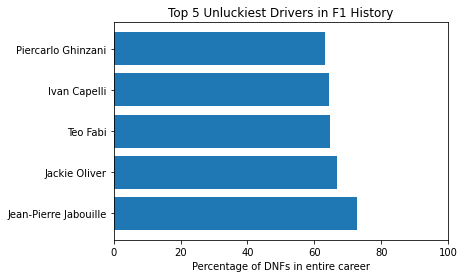

In [50]:
fig, ax = plt.subplots()
driver_list = []
stat = []

for pairs in sorted_percentage_DNFs[:5]:
    driver_list.append(drivers[drivers['driverId'] == pairs[0]]['forename'].values[0] + " " + drivers[drivers['driverId'] == pairs[0]]['surname'].values[0])
    stat.append(pairs[1][0])

plt.barh(driver_list, stat)
ax.set_title('Top 5 Unluckiest Drivers in F1 History')
plt.xlabel("Percentage of DNFs in entire career")
plt.xlim(0,100)

plt.show()

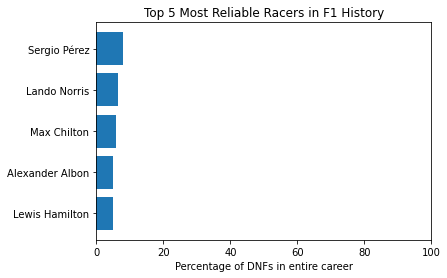

In [51]:
fig, ax = plt.subplots()
driver_list = []
stat = []
for pairs in sorted_percentage_DNFs[:-6:-1]:
    driver_list.append(drivers[drivers['driverId'] == pairs[0]]['forename'].values[0] + " " +  drivers[drivers['driverId'] == pairs[0]]['surname'].values[0])
    stat.append(pairs[1][0])
    
plt.barh(driver_list, stat)
ax.set_title('Top 5 Most Reliable Racers in F1 History')
plt.xlabel("Percentage of DNFs in entire career")
plt.xlim(0,100)

plt.show()

So, we can see that the people with the least luckiest career is Jean-Pierre Jabouille. He started in 49 races, but about 73% of his total races ended in some sorts of retirements. 

On the other hand, we can see that the driver who finished the most percentage of his races is Lewis Hamilton. This is no surprise due to his consistent fight in the championship. 
Surprising, Alex Albon is right on the chart for finishing the race reliably. With his re-entrance to F1 in the 2022 season, Alex is out to finish more races for sure.

# Conclusion

This data set contains some very detailed information on the entire history of the sport. I am confident that a person with a deep understanding of racing and an appreciation for the sport can produce some amazing results with this data set. The work that I have conducted here is my attempt to think like a data scientist, and try to quantify the advantages that Mercedes had during the hybrid era. It is astonishing to see how Lewis Hamilton was able to perform at such a high level throughout the years. It is also thrilling to see that human talent like Nico Rosberg can still make a great impact on the outcome of the championship. 